In [1]:
import sys
import os
nu_russell = os.path.realpath(os.path.join(os.getcwd(),'..','..'))
sys.path.insert(0,nu_russell)
import neuronunit
import dask.bag as db
from neuronunit.optimization import optimization_management as om
import pickle



In [2]:
# http://www.physics.usyd.edu.au/teach_res/mp/mscripts/
# ns_izh002.m
import collections
from collections import OrderedDict

# Fast spiking cannot be reproduced as it requires modifications to the standard Izhi equation,
# which are expressed in this mod file.
# https://github.com/OpenSourceBrain/IzhikevichModel/blob/master/NEURON/izhi2007b.mod

reduced2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('RTN',       (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('RTN_burst', (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7))])

import numpy as np
reduced_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])

#OrderedDict
for i,k in enumerate(reduced_dict.keys()):
    for v in reduced2007.values():
        reduced_dict[k].append(v[i])

explore_param = {k:(np.min(v),np.max(v)) for k,v in reduced_dict.items()}
param_ranges = OrderedDict(explore_param)

#IB = mparams[param_dict['IB']]
RS = {}
IB = {}
TC = {}
CH = {}
RTN_burst = {}
cells = OrderedDict([(k,[]) for k in ['RS','IB','CH','LTS','FS','TC','TC_burst','RTN','RTN_busrt']])
reduced_cells = OrderedDict([(k,[]) for k in ['RS','IB','LTS','TC','TC_burst']])

for index,key in enumerate(reduced_cells.keys()):
    reduced_cells[key] = {}
    for k,v in reduced_dict.items():
        reduced_cells[key][k] = v[index]

print(reduced_cells)
cells = reduced_cells

OrderedDict([('RS', {'c': -50, 'vt': -40, 'a': 0.03, 'b': -2, 'd': 100, 'C': 100, 'k': 0.7, 'vr': -60, 'vPeak': 35}), ('IB', {'c': -56, 'vt': -45, 'a': 0.01, 'b': 5, 'd': 130, 'C': 150, 'k': 1.2, 'vr': -75, 'vPeak': 50}), ('LTS', {'c': -53, 'vt': -42, 'a': 0.03, 'b': 8, 'd': 20, 'C': 100, 'k': 1.0, 'vr': -56, 'vPeak': 40}), ('TC', {'c': -60, 'vt': -50, 'a': 0.01, 'b': 15, 'd': 10, 'C': 200, 'k': 1.6, 'vr': -60, 'vPeak': 35}), ('TC_burst', {'c': -60, 'vt': -50, 'a': 0.01, 'b': 15, 'd': 10, 'C': 200, 'k': 1.6, 'vr': -60, 'vPeak': 35})])


In [3]:
model = None
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization import get_neab

from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']


model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(cells['TC'])



In [4]:
tests_,all_tests, observation,suite = get_neab.get_tests()
#tests_,all_tests, observation,suite = opt.get_neab.get_tests()
rheobase = all_tests[0].generate_prediction(model)
print(rheobase)

{'value': array(74.921875) * pA}


In [5]:
print(all_tests)

[<neuronunit.tests.fi.RheobaseTestP object at 0x7f812082a940>, <neuronunit.tests.passive.InputResistanceTest object at 0x7f8120830c18>, <neuronunit.tests.passive.TimeConstantTest object at 0x7f812082a5f8>, <neuronunit.tests.passive.CapacitanceTest object at 0x7f812082a898>, <neuronunit.tests.passive.RestingPotentialTest object at 0x7f812082a828>, <neuronunit.tests.waveform.InjectedCurrentAPWidthTest object at 0x7f812082a9e8>, <neuronunit.tests.waveform.InjectedCurrentAPAmplitudeTest object at 0x7f812082aa58>, <neuronunit.tests.waveform.InjectedCurrentAPThresholdTest object at 0x7f812082aa90>]


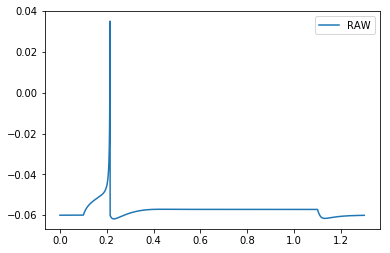

In [6]:
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq

from neuronunit.optimization.data_transport_container import DataTC
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(cells['TC'])

iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] =75.36800000000001*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

model.inject_square_current(iparams)

plt.plot(model.get_membrane_potential().times,model.get_membrane_potential(),label='RAW')
plt.legend()
plt.show()

In [7]:
cnt = 0
scores = []


In [8]:
def format_iparams(all_tests,rheobase):

    for t in all_tests[1:5]:
        DURATION = 500.0*pq.ms
        DELAY = 200.0*pq.ms

        obs = t.observation
        t.params = {}
        t.params['injected_square_current'] = {}
        t.params['injected_square_current']['delay']= DELAY
        t.params['injected_square_current']['duration'] = DURATION
        t.params['injected_square_current']['amplitude'] = -10*pq.pA
        
        
    for t in all_tests[-3::]:    
        t.params = {}
        DURATION = 1000.0*pq.ms
        DELAY = 100.0*pq.ms

        t.params['injected_square_current'] = {}
        t.params['injected_square_current']['delay']= DELAY
        t.params['injected_square_current']['duration'] = DURATION
        t.params['injected_square_current']['amplitude'] = rheobase['value']
    
    all_tests[0].params = all_tests[-1].params
    
    return all_tests

pt = format_iparams(all_tests,rheobase)
print([t.params['injected_square_current']['amplitude'] for t in pt[-3::] ])
print([t.params['injected_square_current']['amplitude'] for t in pt[0:5] ])

[array(74.921875) * pA, array(74.921875) * pA, array(74.921875) * pA]
[array(74.921875) * pA, array(-10.0) * pA, array(-10.0) * pA, array(-10.0) * pA, array(-10.0) * pA]



# * Get predictions from models.
## * Fake NeuroElectro Observations
## * Do roundtrip testing


In [9]:
predictions = []

# The rheobase has been obtained seperately and cannot be db mapped.
# Nested DB mappings dont work (daemons cannot spawn daemonic processes).
ptbag = db.from_sequence(pt[1::])

def obtain_predictions(t):    
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(cells['TC'])
    return t.generate_prediction(model)
predictions = list(ptbag.map(obtain_predictions).compute())
predictions.insert(0,rheobase)
print(predictions)    

[{'value': array(74.921875) * pA}, {'value': array(31739282.99824782) * kg*m**2/(s**3*A**2)}, {'value': array(0.0034631849083750876) * s}, {'value': array(1.0911352057216523e-10) * s**4*A**2/(kg*m**2)}, {'mean': array(-0.060317405613048956) * V, 'std': array(0.00019622743842309925) * V}, {'mean': array(0.000675) * s, 'n': 1, 'std': array(0.0) * s}, {'mean': array(0.05802236247240052) * V, 'n': 1, 'std': array(0.0) * V}, {'mean': array(-0.02302236247240052) * V, 'n': 1, 'std': array(0.0) * V}]


In [10]:
# having both means and values in dictionary makes it very irritating to iterate over.
# It's more harmless to demote means to values, than to elevate values to means.
# Simply swap key names: means, for values.
for p in predictions:
    if 'mean' in p.keys():
        p['value'] = p.pop('mean')
print(predictions)

[{'value': array(74.921875) * pA}, {'value': array(31739282.99824782) * kg*m**2/(s**3*A**2)}, {'value': array(0.0034631849083750876) * s}, {'value': array(1.0911352057216523e-10) * s**4*A**2/(kg*m**2)}, {'std': array(0.00019622743842309925) * V, 'value': array(-0.060317405613048956) * V}, {'n': 1, 'std': array(0.0) * s, 'value': array(0.000675) * s}, {'n': 1, 'std': array(0.0) * V, 'value': array(0.05802236247240052) * V}, {'n': 1, 'std': array(0.0) * V, 'value': array(-0.02302236247240052) * V}]


# Make some new tests based on internally generated data 
 as opposed to experimental data.

In [11]:


TC_tests = copy.copy(all_tests)
for ind,t in enumerate(TC_tests):
    if 'mean' in t.observation.keys():
        t.observation['value'] = t.observation.pop('mean')
    pred =  predictions[ind]['value']
    try:
        pred = pred.rescale(t.units)
        t.observation['value'] = pred
    except:        
        t.observation['value'] = pred
    t.observation['mean'] = t.observation['value']
    #t.observation['std'] = 0.0
    
    if float(t.observation['std']) == 0.0:
        print('got here')
        t.observation['std'] = 5.0*t.observation['mean'].units
    
pickle.dump(TC_tests,open('thalamo_cortical_tests.p','wb'))    







## Call Genetic Algorithm optimizer


In [12]:
from neuronunit.optimization import optimization_management as om
free_params = ['a','b','vr','vt','k'] # this can only be odd numbers.
#2**3
hc = {}
for k,v in cells['TC'].items():
    if k not in free_params:
        hc[k] = v
#print(hc)
import pickle
TC_tests = pickle.load(open('thalamo_cortical_tests.p','rb'))    
                #run_ga(model_params, max_ngen, test, free_params = None, hc = None)
    
#ga_out, DO = om.run_ga(explore_param,10,TC_tests,free_params=free_params,hc = hc, NSGA = False, MU = 10)
    
#ga_out_nsga, _ = om.run_ga(explore_param,1,TC_tests,free_params=free_params,hc = hc, NSGA = True)

In [13]:
from neuronunit.optimization import optimization_management as om
free_params = ['a','b','vr','vt','k'] # this can only be odd numbers.
#2**3
hc = {}
for k,v in cells['TC'].items():
    if k not in free_params:
        hc[k] = v
#print(hc)
import pickle
try:
    #assert 1==2
    ga_out_nsga = pickle.load(open('chatter_ga_out_nsga.p','rb'))
    
except:
    TC_tests = pickle.load(open('thalamo_cortical_tests.p','rb'))    
    ga_out_nsga, _ = om.run_ga(explore_param,25,TC_tests,free_params=free_params,hc = hc, NSGA = True)
    pickle.dump(ga_out_nsga,open('chatter_ga_out_nsga.p','wb'))

    

In [14]:
pickle.dump(ga_out_nsga,open('chatter_ga_out_nsga.p','wb'))



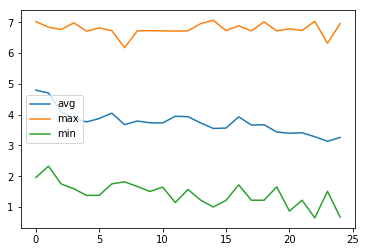

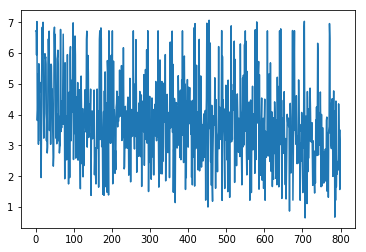

In [15]:

for item in ['avg','max','min']:
    plt.plot([x[item] for x in ga_out_nsga['log']],label=item)
plt.legend()
plt.show()

history = ga_out_nsga['history']
hof = ga_out_nsga['hof']
temp = [ v.dtc for k,v in history.genealogy_history.items() ]
temp = [ i for i in temp if type(i) is not type(None)]
temp = [ i for i in temp if len(list(i.attrs.values()))  ]
true_history = [ (v, np.sum(list(v.scores.values()))) for v in temp ]
plt.plot([i for i,j in enumerate(true_history)],[ i[1] for i in true_history ])


In [16]:
true_history = ga_out_nsga['hardened']
true_mins = sorted(true_history, key=lambda h: h[1])

print(true_mins[0][1], true_mins[0][0])
try:
    if true_mins[0][1] < np.sum(list(hof[0].dtc.scores.values())):
        #print('history unreliable')
        hof = [i[0] for i in true_mins]
        best = hof[0]
        best_attrs = best.attrs
    else:
        best = ga_out_nsga['dhof'][0]
        best_attrs = ga_out_nsga['dhof'][0].attrs
        ga_out_nsga['dhof'][0].scores
except:
    best = ga_out_nsga['dhof'][0]
    best_attrs = ga_out_nsga['dhof'][0].attrs
    ga_out_nsga['dhof'][0].scores
#true_mins    

0.643622317713 <neuronunit.optimization.data_transport_container.DataTC object at 0x7f811f689668>


In [17]:
best = true_mins[0][0]
best_attrs = true_mins[0][0].attrs

In [18]:
print(best.rheobase)

print('best',best.get_ss())

72.9765625 pA
best 0.643622317713


# with five parameters, and 20 generations a really good fit can be found

{'a': 0.01, 'b': 15, 'C': 200, 'k': 1.6, 'vr': -60, 'vPeak': 35, 'c': -60, 'vt': -50, 'd': 10}


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


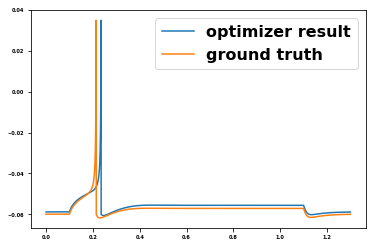

100.0 ms
dict_keys(['amplitude', 'delay', 'duration'])
52000 52200


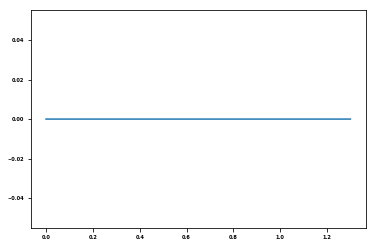

In [57]:
fig = plt.figure()

model1 = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model1.attrs.update(best_attrs)
rheobase = best.rheobase
iparams['injected_square_current']['amplitude'] = rheobase
model1.inject_square_current(iparams) # this one is rheobase firing failure.

model2 = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model2.set_attrs(cells['TC'])
model2.attrs.update(cells['TC'])


iparams['injected_square_current']['amplitude'] =75.36800000000001*pq.pA
model2.inject_square_current(iparams) # this one is rheobase success.

print(model2.attrs)

times = model1.get_membrane_potential().times
plt.plot(times,model1.get_membrane_potential(),label='optimizer result')
plt.plot(times,model2.get_membrane_potential(),label='ground truth') #fires
plt.legend()
 #fires
plt.show()
delay = iparams['injected_square_current']['delay']
print(delay)
dur = iparams['injected_square_current']['duration']
print(iparams['injected_square_current'].keys())
width = int(delay/len(times))+int(dur/len(times))
current1 = [75.36800000000001 for i in times]
#current0 = [0 

first_int = len(times)/delay
second_int = len(times)/dur

for i in range(0,int(first_int)):
    current1[i] = 0
     

for i in range(int(second_int),len(times)):
    current1[i] = 0
     
        
#current0.extend(current1)
#current2 = [0 for i in range(0,int(100)) ]
#current0.extend(current2)

print(len(times),len(current0))
plt.plot(times,current1,label='current')


#plt.show(bbox_inches='tight')
#plt.tight_layout()
#plt.subplots_adjust(left=0.2,right=0.8)
#fig.tight_layout()

In [20]:
abs_max = true_mins[-1][1]
abs_min = true_mins[0][1]
pop = ga_out_nsga['pop']
print(ga_out_nsga['hof'][0].dtc.get_ss())
ga_out_nsga['hardened'][0]

0.643622317713


(<neuronunit.optimization.data_transport_container.DataTC at 0x7f811f689668>,
 0.64362231771345146)

GrayCode(5)


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


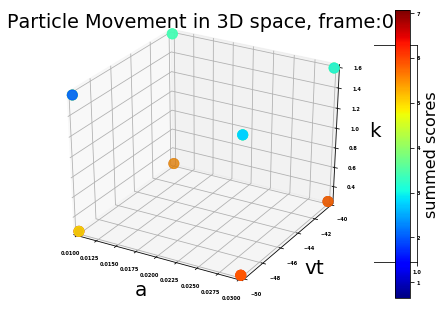

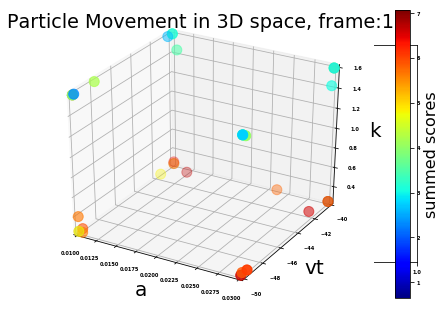

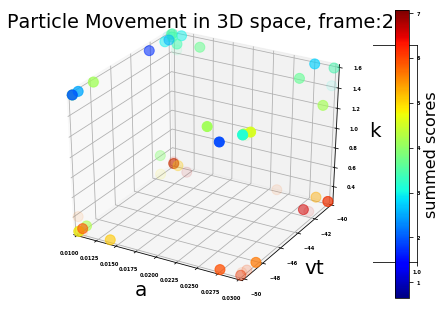

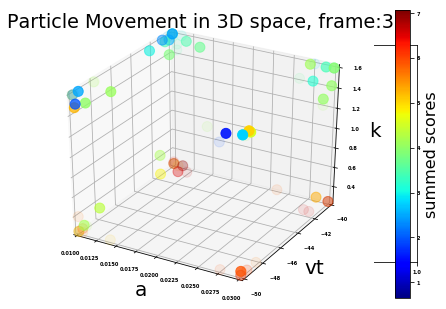

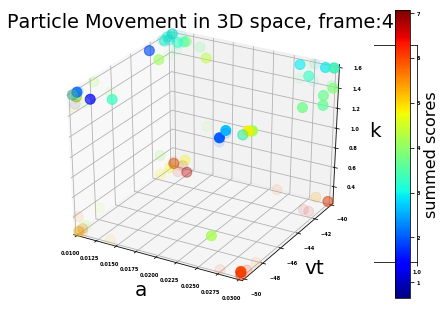

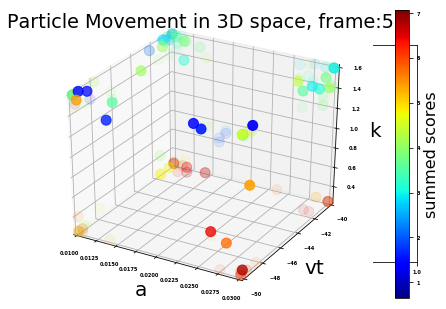

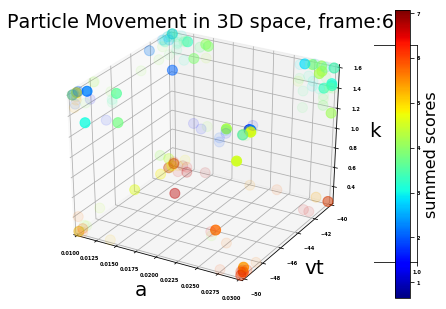

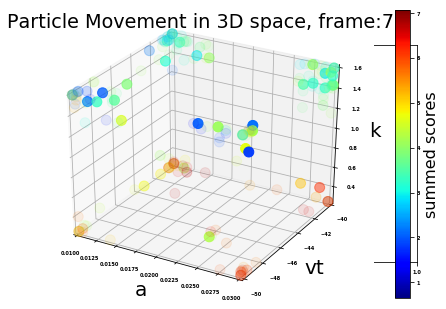

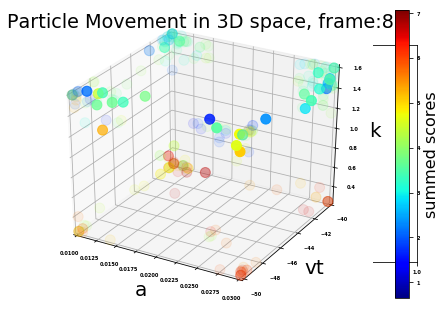

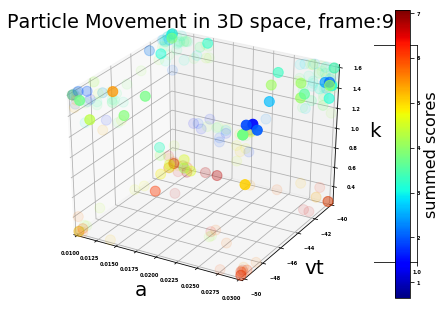

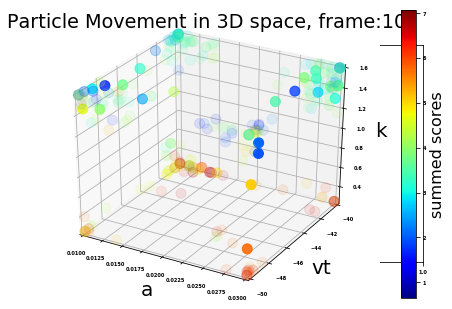

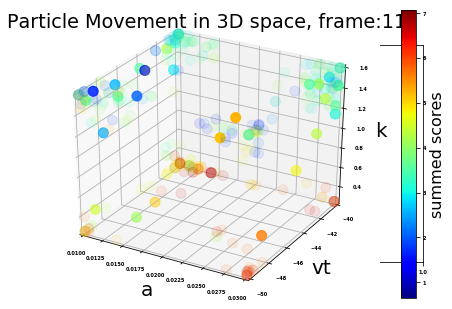

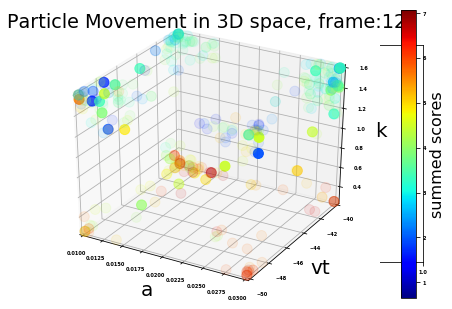

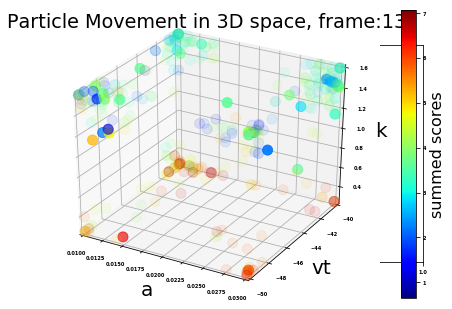

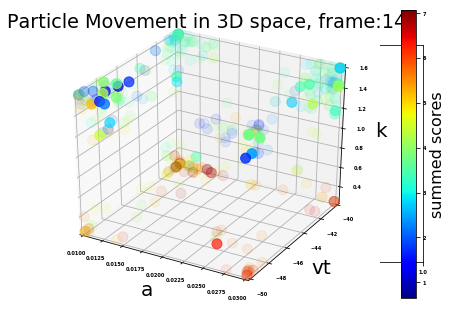

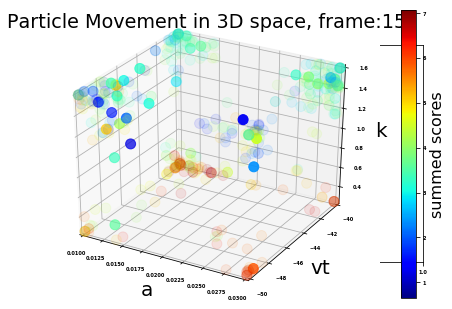

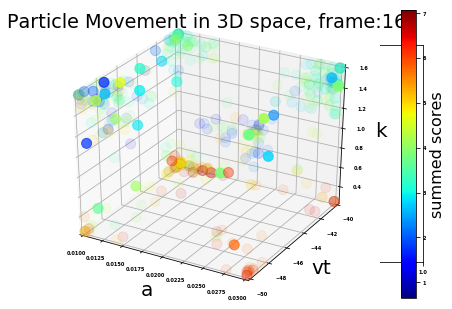

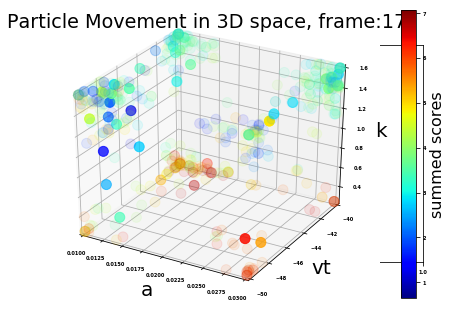

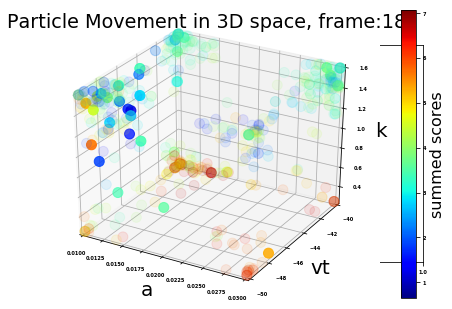

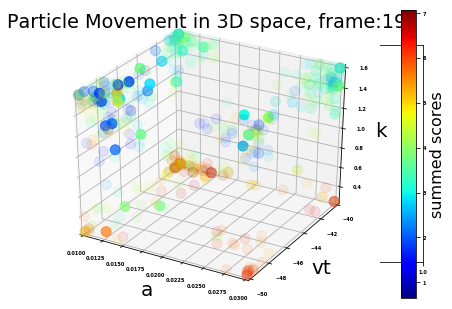

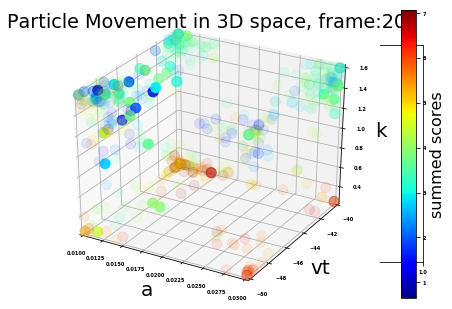

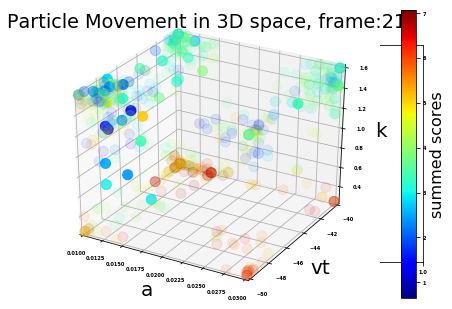

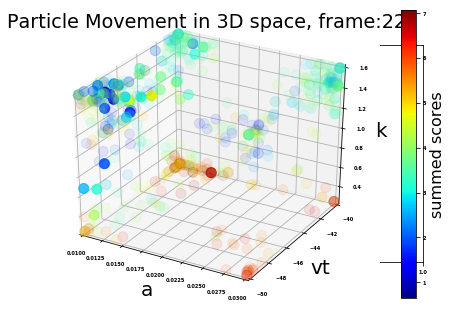

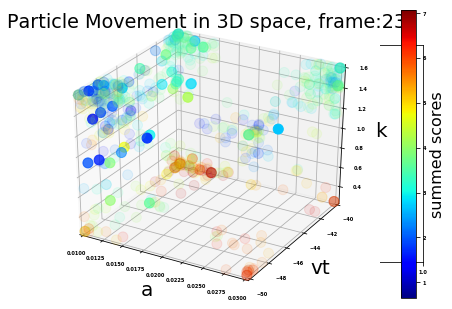

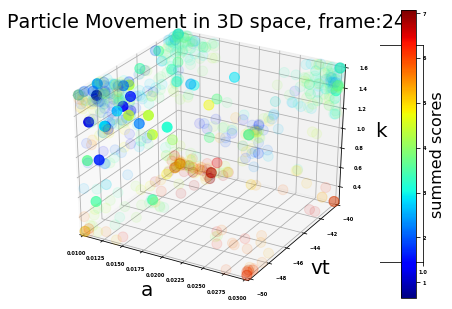

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from matplotlib import animation, rc
from IPython.display import HTML
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)
plt.rc('xtick', labelsize=5)    # fontsize of the tick labels
plt.rc('ytick', labelsize=5)
super_set = []
gen_vs_pop = ga_out_nsga['gen_vs_pop']

length = len(gen_vs_pop)

lims = []
for k,v in pop[0].dtc.attrs.items():
    lims.append([np.min(explore_param[k]), np.max(explore_param[k])])

x = 0
y = 1
z = 2
plt.clf()
from collections import OrderedDict


from sympy.combinatorics.graycode import GrayCode
a = GrayCode(5)
print(a)
pre_empt = list(a.generate_gray())

for i, pop in enumerate(gen_vs_pop):
    other_points = []
    pf_points = []
    hof_points = []    
    labels = []
    od = OrderedDict(pop[0].dtc.attrs)
    for p in pop:
        
        xyz = []
        for k in od.keys():
            v = p.dtc.attrs[k]
            xyz.append(v)
            labels.append(k)
        other_points.append(xyz)
    best_xyz = []
    
    #for k,v in values():   
    for k in od.keys():
        v = ga_out_nsga['hof'][0].dtc.attrs[k]
        best_xyz.append(v)
    best_error = ga_out_nsga['hof'][0].dtc.get_ss()

    fig = plt.figure()
    fig, ax = plt.subplots(1, 1)#, figsize=figsize)
    ax = Axes3D(fig)
    

    ax.set_xlim(lims[x])
    ax.set_ylim(lims[y])
    ax.set_zlim(lims[z])
    
    title='Particle Movement in 3D space, frame:' +str(i)#,
    title_fontsize="large"#,
    text_fontsize="medium"
    ax.set_title(title, fontsize=title_fontsize)


    errors = [ p.dtc.get_ss() for p in pop ]
    xx = [ i[x] for i in other_points ]
    yy = [ i[y] for i in other_points ]
    zz = [ i[z] for i in other_points ]
    if len(super_set) !=0 :
        for ss in super_set:
            ops, ers = ss
            p0 = ax.scatter3D([i[0] for i in ops], [ i[1] for i in ops], [i[2] for i in ops], s=100, alpha=0.0925, c=ers, cmap='jet', marker='o', vmin=abs_min, vmax=abs_max)

    p1 = ax.scatter3D(xx, yy, zz, c=errors, cmap='jet', marker='o', s=100, vmin=abs_min, vmax=abs_max)
    if i == length:
        p2 = ax.scatter3D(best_xyz[x], best_xyz[y], best_xyz[z], c=best_error, cmap='jet', marker='o', s=100, vmin=abs_min, vmax=abs_max)

    cb = fig.colorbar(p1)
    cb.set_label('summed scores')

    ax.set_xlabel(str(labels[x]))
    ax.set_ylabel(str(labels[y]))
    ax.set_zlabel(str(labels[z]))
    for item in ([ax.xaxis.label, ax.yaxis.label, ax.zaxis.label]):
        item.set_fontsize(20)
        
    #for item in ([ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()]):
    #    item.set_fontsize(10)    
    plt.savefig(str(i)+str('.png'))
    super_set.append((other_points,errors))    
    plt.show()
    
# ls -v *.png >> sorted.txt    
# convert -delay 100 -loop 0 @sorted.txt animation.mp4    
  

GrayCode(5)


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


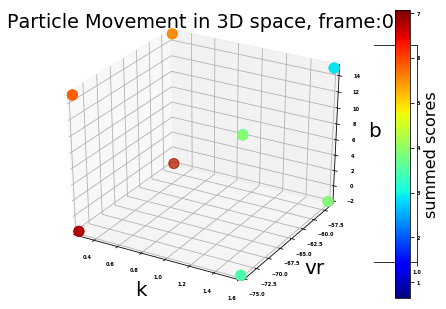

gets here


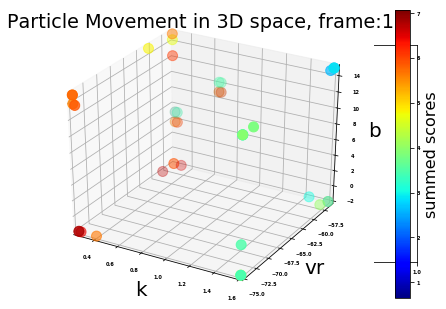

gets here
gets here


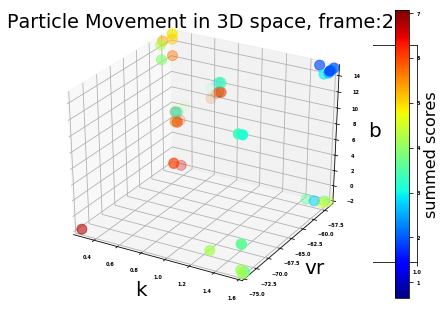

gets here
gets here
gets here


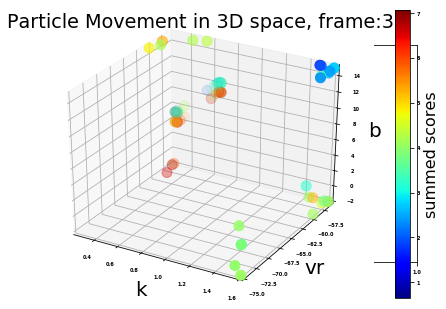

gets here
gets here
gets here
gets here


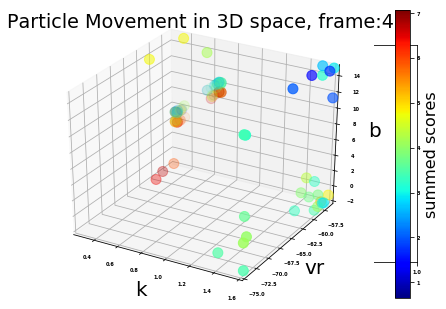

gets here
gets here
gets here
gets here
gets here


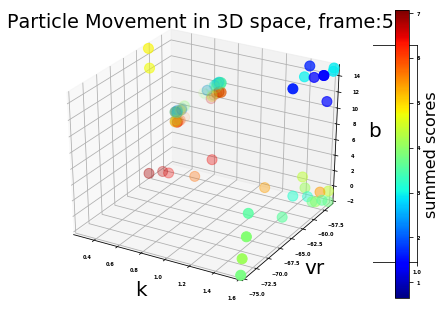

gets here
gets here
gets here
gets here
gets here
gets here


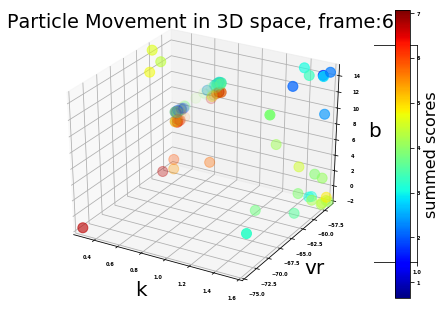

gets here
gets here
gets here
gets here
gets here
gets here
gets here


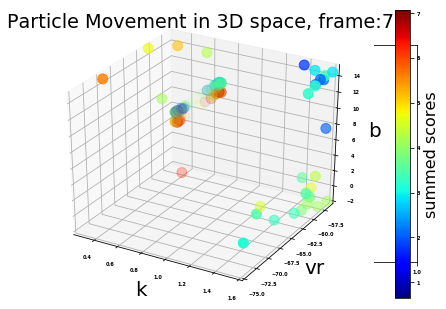

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


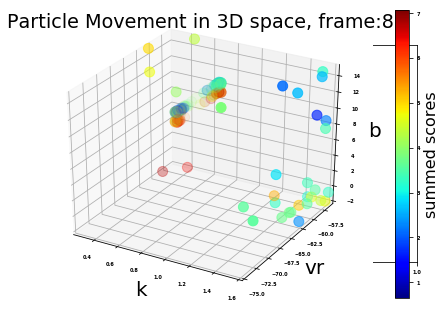

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


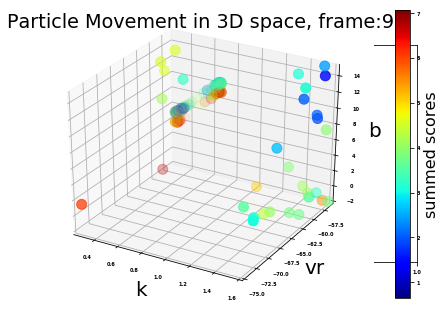

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


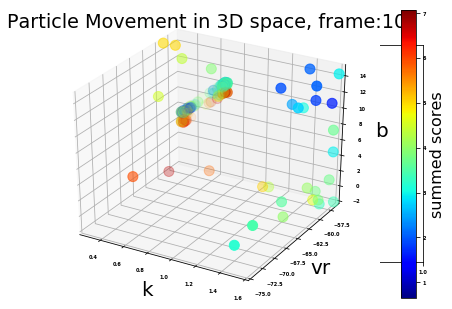

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


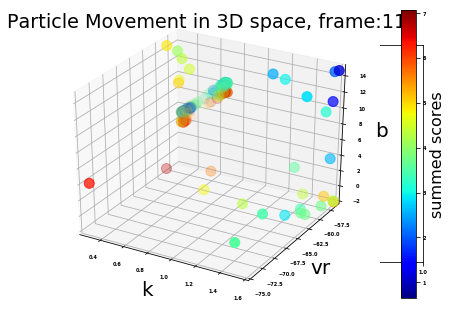

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


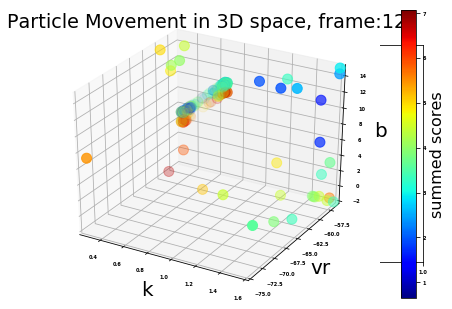

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


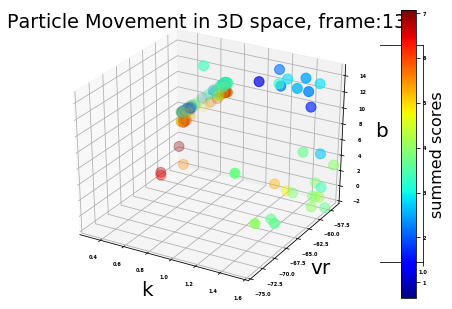

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


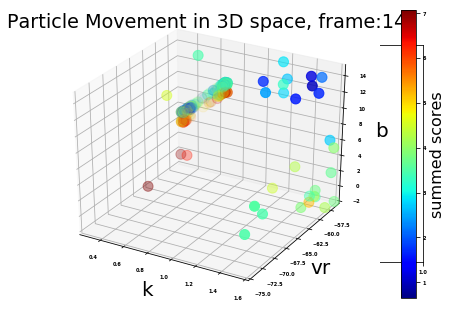

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


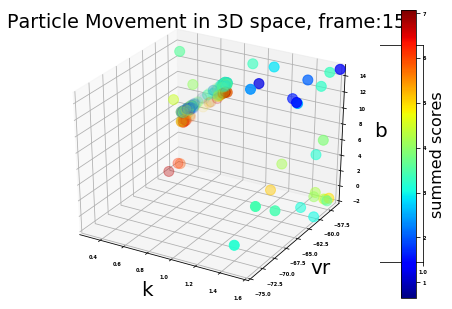

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


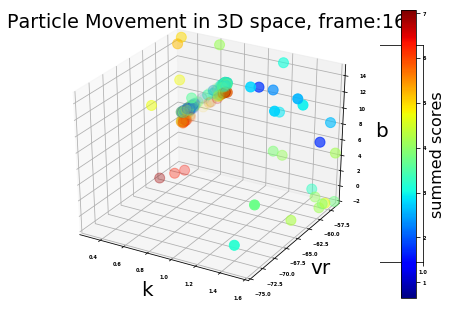

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


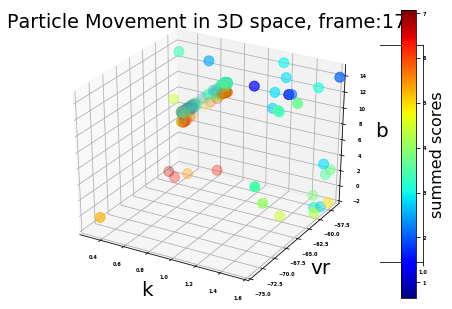

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


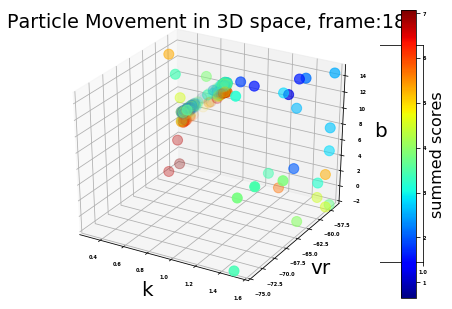

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


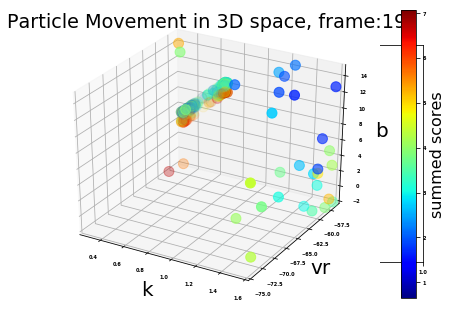

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


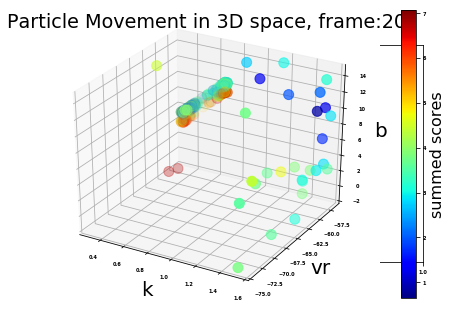

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


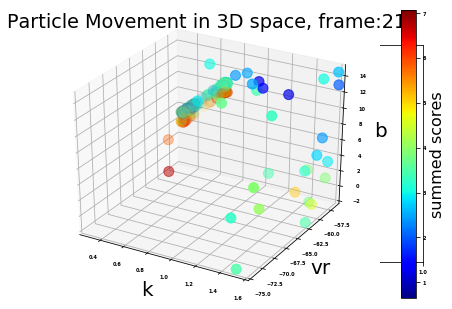

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


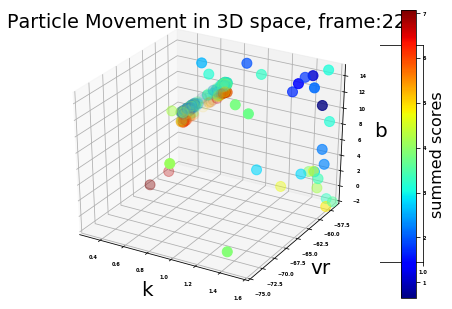

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


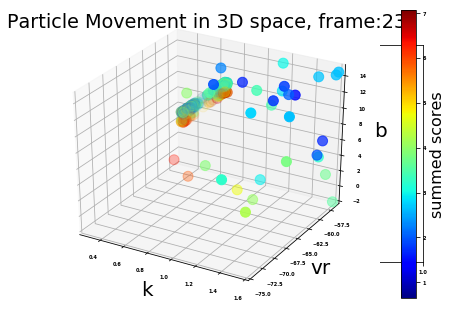

gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here
gets here


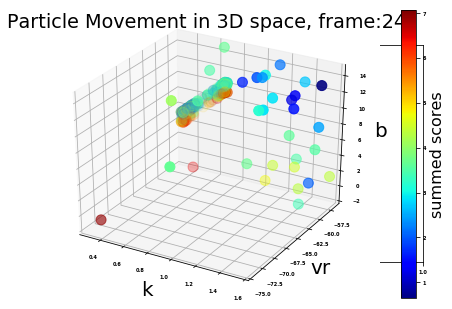

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from matplotlib import animation, rc
from IPython.display import HTML

from matplotlib import animation, rc
from IPython.display import HTML
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)
plt.rc('xtick', labelsize=5)    # fontsize of the tick labels
plt.rc('ytick', labelsize=5)


super_set = []
gen_vs_pop = ga_out_nsga['gen_vs_pop']

length = len(gen_vs_pop)

lims = []
for k,v in pop[0].dtc.attrs.items():
    lims.append([np.min(explore_param[k]), np.max(explore_param[k])])

x = 2
y = 3
z = 4
plt.clf()
from collections import OrderedDict


from sympy.combinatorics.graycode import GrayCode
a = GrayCode(5)
print(a)
pre_empt = list(a.generate_gray())

for i, pop in enumerate(gen_vs_pop):
    other_points = []
    pf_points = []
    hof_points = []    
    labels = []
    od = OrderedDict(pop[0].dtc.attrs)
    for p in pop:
        
        xyz = []
        for k in od.keys():
            v = p.dtc.attrs[k]
            xyz.append(v)
            labels.append(k)
        other_points.append(xyz)
    best_xyz = []
    
    #for k,v in values():   
    for k in od.keys():
        v = ga_out_nsga['hof'][0].dtc.attrs[k]
        best_xyz.append(v)
    best_error = ga_out_nsga['hof'][0].dtc.get_ss()

    fig = plt.figure()
    fig, ax = plt.subplots(1, 1)#, figsize=figsize)
    ax = Axes3D(fig)
    

    ax.set_xlim(lims[x])
    ax.set_ylim(lims[y])
    ax.set_zlim(lims[z])
    
    title='Particle Movement in 3D space, frame:' +str(i)#,
    title_fontsize="large"#,
    text_fontsize="medium"
    ax.set_title(title, fontsize=title_fontsize)


    errors = [ p.dtc.get_ss() for p in pop ]
    xx = [ i[x] for i in other_points ]
    yy = [ i[y] for i in other_points ]
    zz = [ i[z] for i in other_points ]
    if len(super_set) !=0 :
        for ss in super_set:
            ops, ers = ss
            print('gets here')
            p0 = ax.scatter3D([i[0] for i in ops], [ i[1] for i in ops], [i[2] for i in ops], s=100, alpha=0.0925, c=ers, cmap='jet', marker='o', vmin=abs_min, vmax=abs_max)

    p1 = ax.scatter3D(xx, yy, zz, c=errors, s=100, cmap='jet', marker='o', vmin=abs_min, vmax=abs_max)
    if i == length:
        p2 = ax.scatter3D(best_xyz[x], best_xyz[y], best_xyz[z], c=best_error, cmap='jet', marker='o', s=100, vmin=abs_min, vmax=abs_max)

    cb = fig.colorbar(p1)
    cb.set_label('summed scores')

    ax.set_xlabel(str(labels[x]))
    ax.set_ylabel(str(labels[y]))
    ax.set_zlabel(str(labels[z]))
    for item in ([ax.xaxis.label, ax.yaxis.label, ax.zaxis.label]):
        item.set_fontsize(20)
        
    plt.savefig(str(i)+str('.png'))
    super_set.append((other_points,errors))    
    plt.show()
  

dict_keys(['hof', 'dhof', 'gen_vs_pop', 'pf', 'history', 'pop', 'td', 'bd', 'dbest', 'hardened', 'log'])

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


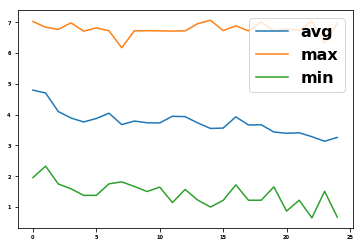

In [23]:
for item in ['avg','max','min']:
    plt.plot([x[item] for x in ga_out_nsga['log']],label=item)
plt.legend()

ga_out_nsga.keys()

#ga_out['gen_vs_pop']

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


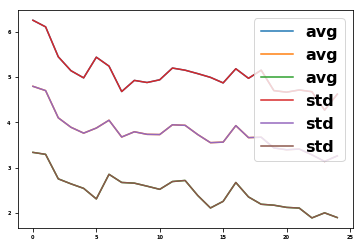

In [24]:

for item in ['avg','std']:
    plt.plot([x['avg']+x['std'] for x in ga_out_nsga['log']],label=item)
    plt.plot([x['avg'] for x in ga_out_nsga['log']],label=item)
    plt.plot([x['avg']-x['std'] for x in ga_out_nsga['log']],label=item)
plt.legend()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


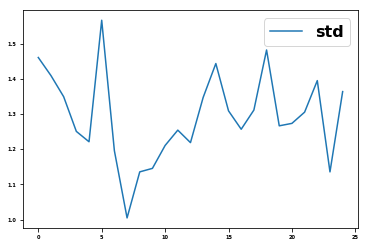

In [25]:
plt.plot([x['std'] for x in ga_out_nsga['log']],label=item)
plt.legend()

In [26]:
#df = df.T
#dfs = []
for i,dhof in enumerate(true_history):
    agreement = {}
    for k,v in dhof[0].score.items():
        print(k,v['value'])
        agreement[k] = v

    dfs.append(agreement)
        
df = pd.DataFrame(dfs)
df = df[0:3]
        
#f, ax = plt.subplots(figsize=(9, 6))
#sns.heatmap(df, annot=True, linewidths=.5, ax=ax, vmin=0, vmax=1)          
df

InjectedCurrentAPAmplitudeTest 0.988486736759166
InputResistanceTest 0.8682789264939796
TimeConstantTest 0.9477166124616718
InjectedCurrentAPWidthTest 0.9254488796223879
RestingPotentialTest 0.8693821053291544
InjectedCurrentAPThresholdTest 0.9732789481058128
CapacitanceTest 0.8163224375616873


NameError: name 'dfs' is not defined

In [ ]:
#df = pd.DataFrame(index=best.scores.keys(),columns=best.scores.keys())
#df = df.T
dfs = []
for i,dhof in enumerate(true_history):
    new = {}
    #print(dir(dhof[0].score))
    for k,v in dhof[0].scores.items():
        if 'Injected' in str(k):
            #print(k,v)
            #print(v)#.prediction
            #v#.observation
            k = k[15::]
        k = k[0:-4]
        new[k] = v
    #if np.nan(dhof[0].scores)

    dfs.append(new)
    
df = pd.DataFrame(dfs)
df = df[0:3]



f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df, annot=True, linewidths=.5, ax=ax, vmin=0, vmax=1)    

In [ ]:
#df = pd.DataFrame(index=best.scores.keys(),columns=best.scores.keys())
#df = df.T
dfs = []
for i,dhof in enumerate(gen_vs_pop[0]):
    new = {}
    for k,v in dhof.dtc.scores.items():
        if 'Injected' in str(k):
            k = k[15::]
        k = k[0:-4]
        new[k] = v
    #if np.nan(dhof[0].scores)

    dfs.append(new)
    
    
from IPython.display import HTML, display
import seaborn as sns

df = pd.DataFrame(dfs)
df = df[0:3]


#dfg = df.reset_index(drop=True)


f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df, annot=True, linewidths=.5, ax=ax, vmin=0, vmax=1)

# Set colormap equal to seaborns light green color palette
#cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm))#,subset=['total']))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load the example flights dataset and conver to long-form
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, fmt="d", linewidths=.5, ax=ax)

In [ ]:
#df = pd.DataFrame(index=best.scores.keys(),columns=best.scores.keys())
df = df.T
dfs = []
for i,dhof in enumerate(true_history):
    new = {}
    for k,v in dhof[0].scores.items():
        if 'Injected' in str(k):
            k = k[15::]
        k = k[0:-4]
        new[k] = v
    #if np.nan(dhof[0].scores)

    dfs.append(new)
    
    
from IPython.display import HTML, display
import seaborn as sns

df = pd.DataFrame(dfs)
df = df[-4::]


dfg = df.reset_index(drop=True)

# Set colormap equal to seaborns light green color palette
cm = sns.light_palette("green", as_cmap=True)
display(dfg.style.background_gradient(cmap=cm))#,subset=['total']))

In [ ]:

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(dfg, annot=True, linewidths=.5, ax=ax)

In [ ]:
score = tests_[0].judge(model1)
score.summarize()
score.sort_key

In [ ]:
from neuronunit.optimization import optimization_management as om
free_params = ['a','b','vr'] # this can only be odd numbers.
2**3
hc = {}
for k,v in cells['TC'].items():
    if k not in free_params:
        hc[k] = v
#print(hc)
import pickle
TC_tests = pickle.load(open('thalamo_cortical_tests.p','rb'))    
                #run_ga(model_params, max_ngen, test, free_params = None, hc = None)
    
#ga_out, DO = om.run_ga(explore_param,10,TC_tests,free_params=free_params,hc = hc, NSGA = False, MU = 10)
    
ga_out_sbest, _ = om.run_ga(explore_param,20,TC_tests,free_params=free_params,hc = hc, NSGA = False)

In [ ]:
for item in ['avg','max','min']:
    plt.plot([x[item] for x in ga_out_sbest['log']],label=item)
plt.legend()


best = ga_out['dhof'][0]
best_attrs = ga_out_sbest['dhof'][0].attrs
print('best nsga',np.sum(list(ga_out_nsga['dhof'][0].scores.values())))
print('best BPO select best: ',np.sum(list(ga_out_sbest['dhof'][0].scores.values())))

In [ ]:
plt.plot([x['std'] for x in ga_out_sbest['log']],label=item)
plt.legend()

In [ ]:
def hack_judge(test_and_models):
    (test, attrs) = test_and_models
    model = None
    obs = test.observation
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(attrs)
    test.generate_prediction(model)
    pred = test.generate_prediction(model)
    score = test.compute_score(obs,pred)
    try:
        print(obs['value'],pred['value'])
    except:
        print(obs['mean'],pred['mean'])
        
    return score

scores = []
for i,t in enumerate(TC_tests):
    test_and_models = (t,cells['TC'])
    score = hack_judge(test_and_models)
    scores.append(score)
print(scores[0].norm_score)    
print(scores[0])    



In [ ]:
print([s.norm_score for s in scores])
print([s.score for s in scores])

score = hack_judge((TC_tests[-3],cells['TC']))
print(score)

In [ ]:
scores = []
for t in TC_tests:
    test_and_models = (t,cells['RS'])
    score = hack_judge(test_and_models)
    scores.append(score)
print(scores[0].norm_score)    
print(scores[0])
print([s.norm_score for s in scores])


In [ ]:
import dask.bag as db
# The rheobase has been obtained seperately and cannot be db mapped.
# Nested DB mappings dont work.
from itertools import repeat
test_a_models = zip(TC_tests[1::],repeat(cells['RS']))
tc_bag = db.from_sequence(test_a_models)

scores = list(tc_bag.map(hack_judge).compute())
scores.insert(0,rheobase)
print(scores)    

In [ ]:
score = TC_tests[0].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
#print(model.get_spike_count())